In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

### Функции для анализа:

In [2]:
def reconstruct(col_name, df, special_val = 9):
    source = df.copy()
    cols = [var for var in df.columns if col_name in var]
    df = df[cols]
    original_col_prep = df.idxmax(axis=1)
    original_col = [int(item[-1]) for item in original_col_prep]
    source[col_name] = original_col
    source.drop(columns = cols, inplace=True)
    return source

In [3]:
def norm_data(df, columns = []):
    for col in columns:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

In [4]:
def denormal(col_name, max_, min_, df):
    df[col_name] = df[col_name]*(max_ - min_) + min_
    return df

In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [6]:
def histplot(col_name, plot_data, c_bins = None, step = 5):
    temp_plot_data = plot_data.copy()    
    for val in temp_plot_data[col_name].unique():
        try:
            int(val)
        except:
            temp_plot_data = temp_plot_data[temp_plot_data[col_name] != val]
    temp_plot_data[col_name] = temp_plot_data[col_name].astype('int32')
    if c_bins == 1:
        c_bins = len(temp_plot_data[col_name].unique())
    clust_count = len(temp_plot_data['cluster'].unique())
    fig, axes = plt.subplots(1, clust_count, figsize=(17, 6)) #, sharex=True, sharey=True, tight_layout=True
    for clust in temp_plot_data['cluster'].unique():
        temp_df = temp_plot_data[temp_plot_data['cluster'] == clust].copy()
        xtick_= list(range(int(temp_plot_data[col_name].min()), int(temp_plot_data[col_name].max()+1), step))
        axes[int(clust)].hist(temp_df[col_name], bins = c_bins)
        axes[int(clust)].grid()
#         axes[int(clust)].set_xticks(xtick_)
        axes[int(clust)].axvline(temp_df[col_name].mean(), color='r', linestyle='dashed', linewidth=1)
        axes[int(clust)].axvline(temp_df[col_name].median(), color='y', linestyle='dashed', linewidth=1)
        axes[int(clust)].text(float(temp_df[col_name].mean()),10,str(round(float(temp_df[col_name].mean()),1)))

In [7]:
def numval(row):
    if type(row['family_finance_12']) in (int, float):
        val = row['family_finance_12']
    else:
        val = row['family_finance_3']
    return val

In [8]:
def cluster_cat(feature, df):
    cl = {}
    for i in df['cluster'].unique():
        temp_sample_cl = df[df['cluster']==i][feature]
        counts = []
        for j in df[feature].unique():
            counts.append(len(temp_sample_cl[temp_sample_cl== j]))
        cl[i] = counts.copy()
    # в этом же порядке записываются ответы в списки в рамках каждого кластера
    print('Порядок записи:', df[feature].unique())
    return cl

In [9]:
def plot_cat(df, work_dict, labels_dict, title):
    plt.rcdefaults()
    fig, ax = plt.subplots(1, 5, figsize=(17, 6))
    for i in df['cluster'].unique():
        rating = labels_dict.values()
        y_pos = np.arange(len(rating))
        count = pd.Series(work_dict[i])*100/sum(work_dict[i])

        ax[int(i)].bar(y_pos, count, align='center')
        ax[int(i)].set_xticks(y_pos)
        ax[int(i)].set_yticks(np.arange(0, 101, 10))
        ax[int(i)].set_xticklabels(rating, rotation = 45, ha="right")
        ax[int(i)].grid(axis= 'y')
        # ax.invert_xaxis()  
        ax[0].set_ylabel('Кiлькiсть, %')
    fig.suptitle(title, fontsize=16)

    plt.show()

### Выгрузка данных

In [10]:
df = pd.read_excel('BB_Wave1-3_MATCH_FILES_Coord_f2f_v1_New.xlsx')
directory = pd.read_excel('BB_Wave1-3_MATCH_FILES_Coord_f2f_v1_New.xlsx', sheet_name=1)

## Вступление 

In [11]:
task1_df = df.copy()
task1_df = task1_df[['A4', 'A8', 'A9']]
for col in task1_df.columns:
    task1_df = task1_df[task1_df[col] != ' ']

In [12]:
count_cat = {}
for i in task1_df['A4'].unique():
    count_cat[i] = len(task1_df[task1_df['A4'] == i])
rev_dict = {
    1:'Цілком позитивно',
    2:'Скоріше позитивно',
    3:'Скоріше негативно',
    4:'Цілком негативно',
    5:'Важко сказати'
}

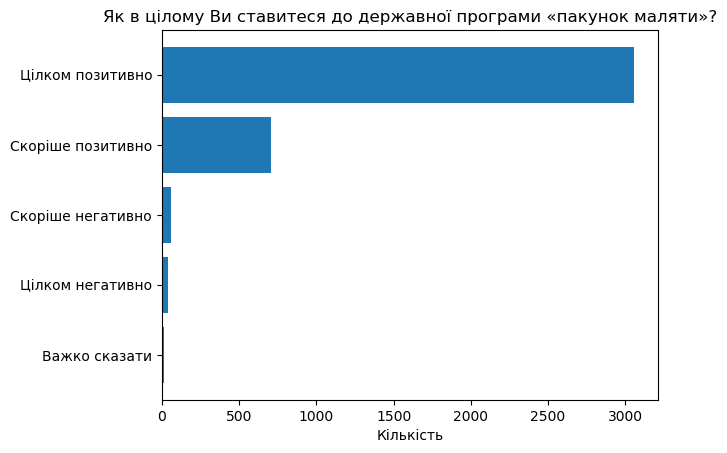

In [13]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
rating = rev_dict.values()
y_pos = np.arange(len(rating))
count = count_cat.values()

ax.barh(y_pos, count, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(rating)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Кiлькiсть')
ax.set_title('Як в цілому Ви ставитеся до державної програми «пакунок маляти»?')

plt.show()

In [14]:
count_cat = {}
for i in task1_df['A8'].unique():
    count_cat[i] = len(task1_df[task1_df['A8'] == i])
rev_dict = {
    1:'5',
    2:'4',
    3:'3',
    4:'2',
    5:'1',
    9: 'Важко сказати'
}

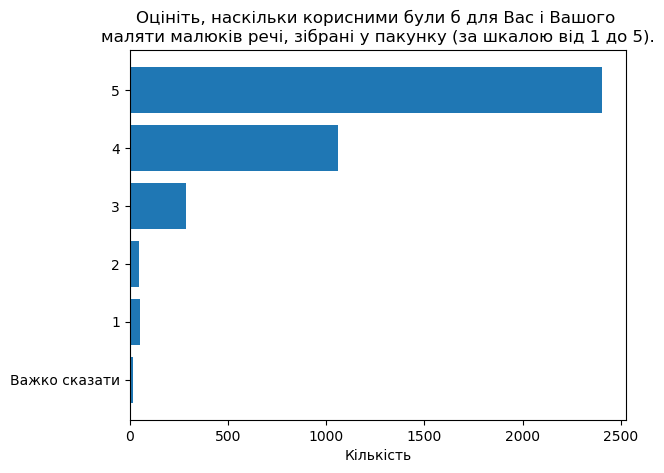

In [15]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
rating = rev_dict.values()
y_pos = np.arange(len(rating))
count = count_cat.values()

ax.barh(y_pos, count, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(rating)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Кiлькiсть')
ax.set_title('Оцініть, наскільки корисними були б для Вас і Вашого \nмаляти малюків речі, зібрані у пакунку (за шкалою від 1 до 5).')

plt.show()

In [16]:
count_cat = {}
for i in task1_df['A9'].unique():
    count_cat[i] = len(task1_df[task1_df['A9'] == i])
rev_dict = {
    1:'Так',
    2:'Hi',
    3: 'Важко сказати'
}

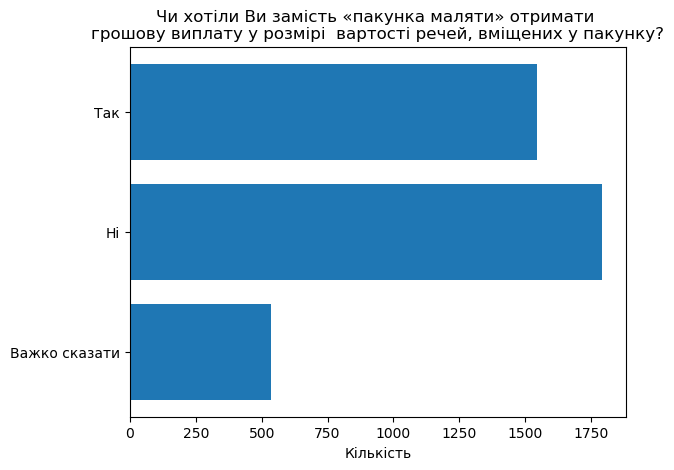

In [17]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
rating = rev_dict.values()
y_pos = np.arange(len(rating))
count = count_cat.values()

ax.barh(y_pos, count, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(rating)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Кiлькiсть')
ax.set_title('Чи хотіли Ви замість «пакунка маляти» отримати \nгрошову виплату у розмірі  вартості речей, вміщених у пакунку?')

plt.show()

## Кластеризация по соц группам

In [18]:
task2_df = df.copy()
task2_df.rename(columns={'C5':'age', 'C8':'family_finance_12', 'С4':'family_finance_3'}, inplace = True)
task2_df['family_finance_3'].replace([1, 2, 3, 4, 5], [5, 4, 3, 2, 1], inplace = True)
task2_df['family_finance'] = task2_df.apply(numval, axis=1)
task2_df = task2_df[task2_df['age'] != ' ']
task2_df = task2_df[task2_df['family_finance'] != 9]
task2_df = task2_df[['age', 'family_finance']]

In [19]:
task2_df_sourse = task2_df[['age', 'family_finance']].copy()
task2_df[['age', 'family_finance']].drop_duplicates()

,age,family_finance
0,24,3
1,26,4
2,30,3
3,38,4
4,26,2
...,...,...
2883,16,1
2935,44,1
2954,43,3
3565,16,4


In [20]:
task2_df = norm_data(task2_df.astype(float), columns=['age','family_finance'])
task2_df

,age,family_finance
0,0.222222,0.50
1,0.277778,0.75
2,0.388889,0.50
3,0.611111,0.75
4,0.277778,0.25
...,...,...
4637,0.333333,0.50
4638,0.666667,0.50
4640,0.194444,0.50
4641,0.361111,0.50


### Выбор количества кластеров для исследования

In [21]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(task2_df)

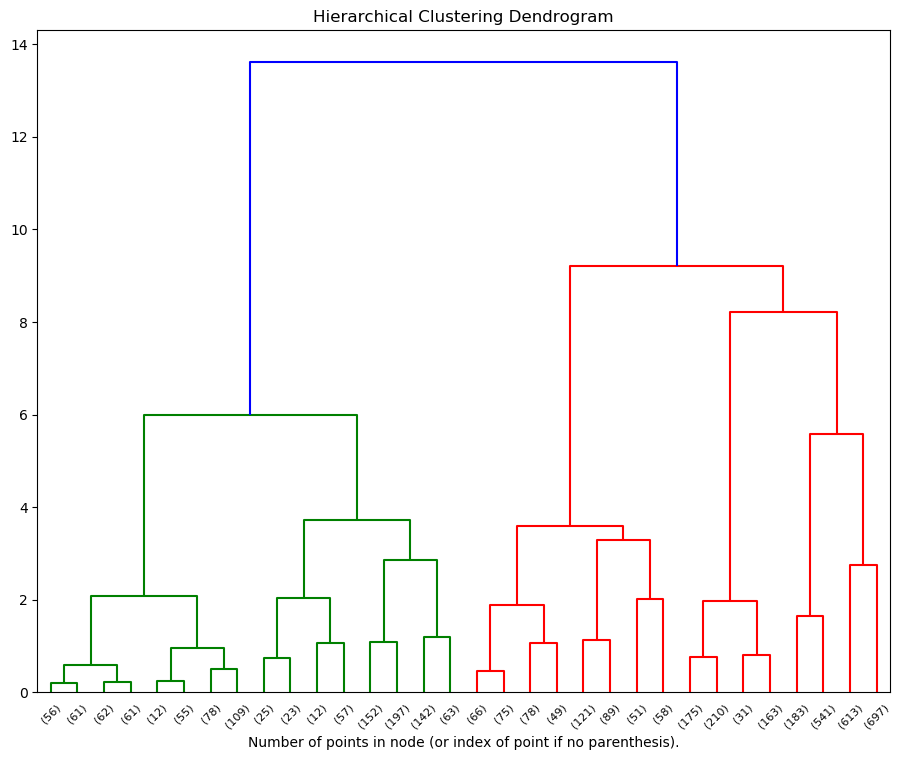

In [22]:
plt.figure(figsize=(11, 8.6))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

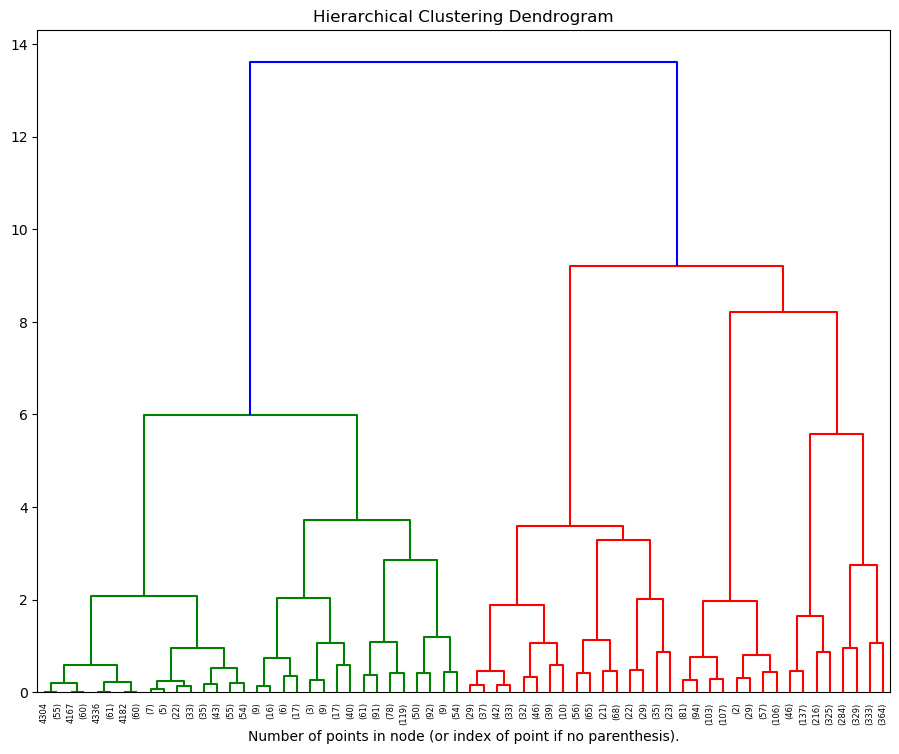

In [23]:
plt.figure(figsize=(11, 8.6))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

### Кластеризация

In [24]:
clust = AgglomerativeClustering(n_clusters=5, linkage = 'complete').fit(task2_df)
task2_df['cluster'] = clust.labels_
task2_df

,age,family_finance,cluster
0,0.222222,0.50,2
1,0.277778,0.75,2
2,0.388889,0.50,4
3,0.611111,0.75,0
4,0.277778,0.25,4
...,...,...,...
4637,0.333333,0.50,4
4638,0.666667,0.50,1
4640,0.194444,0.50,2
4641,0.361111,0.50,4


In [25]:
task2_df = denormal('age', task2_df_sourse['age'].max(), task2_df_sourse['age'].min(), task2_df)
task2_df = denormal('family_finance', task2_df_sourse['family_finance'].max(),
                    task2_df_sourse['family_finance'].min(), task2_df)

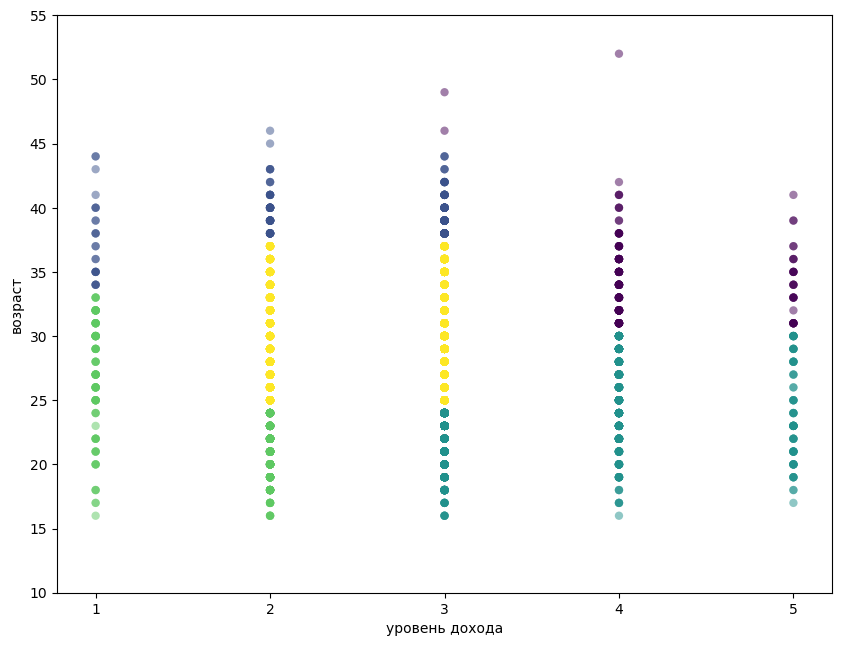

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 7.5)
ax.set_ylim(10, 55)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlabel('уровень дохода')
ax.set_ylabel('возраст')
ax.scatter(task2_df['family_finance'], task2_df['age'], c= task2_df['cluster'], 
           alpha=0.5, edgecolors='none')

In [27]:
clusters = {}
for cl in task2_df['cluster'].unique():
    clusters[cl] = task2_df[task2_df['cluster'] == cl]

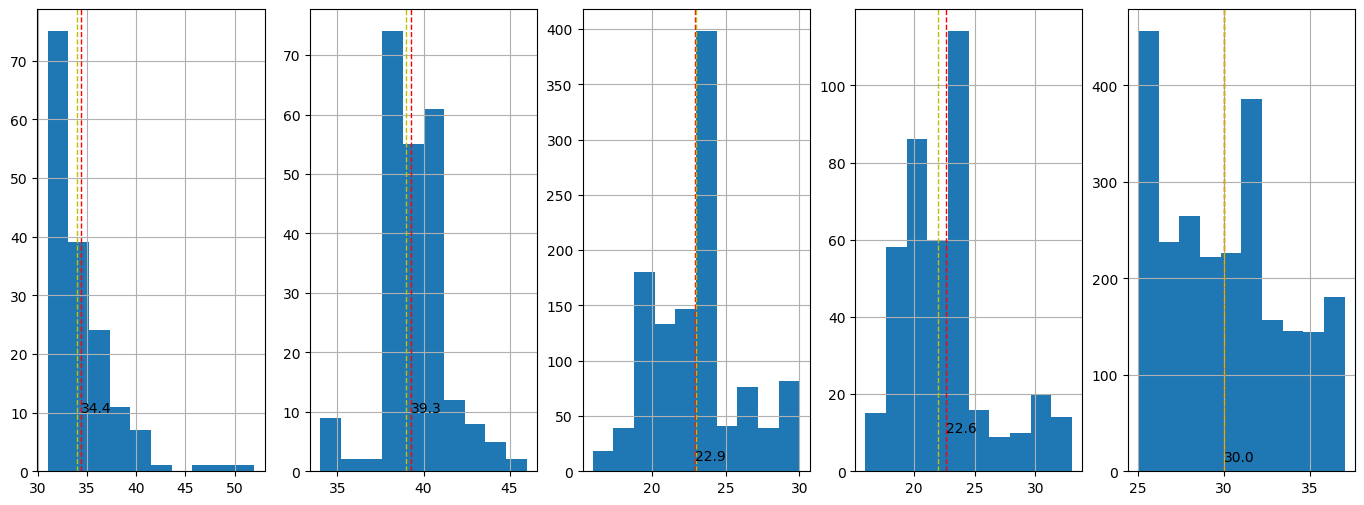

In [28]:
histplot('age', task2_df) #, c_bins = 10

In [29]:
for i in range(len(clusters.keys())):
    print(f'mean {i} cluster: {clusters[i]["age"].mean()}')
    print(f'median {i} cluster: {clusters[i]["age"].median()}')

mean 0 cluster: 34.39375
median 0 cluster: 34.0
mean 1 cluster: 39.28260869565217
median 1 cluster: 39.0
mean 2 cluster: 22.94189071986123
median 2 cluster: 23.0
mean 3 cluster: 22.614427860696516
median 3 cluster: 22.0
mean 4 cluster: 29.987603305785125
median 4 cluster: 30.0


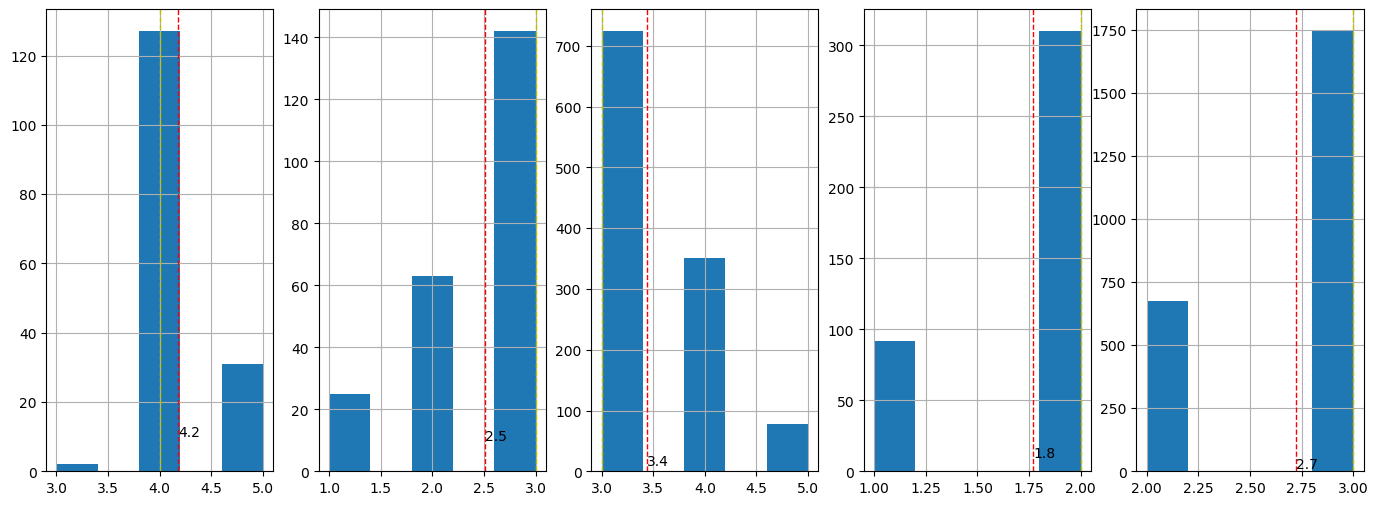

In [30]:
histplot('family_finance', task2_df, c_bins = 5) 

In [31]:
for i in range(len(clusters.keys())):
    print(f'mean {i} cluster: {clusters[i]["family_finance"].mean()}')
    print(f'median {i} cluster: {clusters[i]["family_finance"].median()}')

mean 0 cluster: 4.18125
median 0 cluster: 4.0
mean 1 cluster: 2.508695652173913
median 1 cluster: 3.0
mean 2 cluster: 3.4397224631396357
median 2 cluster: 3.0
mean 3 cluster: 1.771144278606965
median 3 cluster: 2.0
mean 4 cluster: 2.7210743801652892
median 4 cluster: 3.0


In [32]:
for i in range(len(clusters.keys())):
    print(f'len {i} cluster: {len(clusters[i])} \t%: {round(len(clusters[i])*100/len(task2_df) , 3)}')

len 0 cluster: 160 	%: 3.666
len 1 cluster: 230 	%: 5.269
len 2 cluster: 1153 	%: 26.415
len 3 cluster: 402 	%: 9.21
len 4 cluster: 2420 	%: 55.441


## Оценка качества кластеризации

Расчет по переменной "возраст"

#### Проверка равенства дисперсий

In [33]:
# словарь мат ожиданий
mean_group={}
for i in task2_df['cluster'].unique():
    mean_group[i] = pd.Series(task2_df[task2_df['cluster']==i]['age']).mean()
mean_group

{2: 22.94189071986123,
 4: 29.987603305785125,
 0: 34.39375,
 1: 39.28260869565217,
 3: 22.614427860696516}

In [34]:
# словарь дисперсий
variance = {}
for i in task2_df['cluster'].unique():
    temp_sample = pd.Series(task2_df[task2_df['cluster']==i]['age'])
    for j in temp_sample:
        variance[i] = pd.Series([(j - mean_group[i])**2 for j in temp_sample]).mean()
variance

{2: 8.939381334111674,
 4: 11.80480499965849,
 0: 11.201210937500004,
 1: 3.628827977315687,
 3: 13.042876413950166}

In [35]:
# словарь объемов
sample_len = {}
for i in task2_df['cluster'].unique():
    sample_len[i] = len(pd.Series(task2_df[task2_df['cluster']==i]['age']))
sample_len

{2: 1153, 4: 2420, 0: 160, 1: 230, 3: 402}

##### Статистика критерия Бартлетта
https://ru.wikipedia.org/wiki/Критерий_Бартлетта

In [36]:
# по учебнику Методы анализу даних:
clusters = list(task2_df['cluster'].unique())
N = len(task2_df)
k = len(task2_df['cluster'].unique())
sp2 = (1/(N-k)) * sum([(sample_len[i]-1) * variance[i] for i in clusters])
c = 1+(1/(3*(k-1))) * (sum([1/(sample_len[i] - 1) for i in clusters]) - 1/(N-k))
M = (N-k)*np.log(sp2) - sum([(sample_len[i] - 1)*np.log(variance[i]) for i in clusters])
T = M/c
T

134.3228273667029

Если Т больше X^2 с k = 5-1 = 4 степенями свободы при уровне значимости 0.05, то гипотеза H0 отвергается.
Табличное значение статистики: 11.1
Вывод дисперсии не равны

##### Статистика модифицированного критерия Бартлетта
https://ru.wikipedia.org/wiki/Критерий_Бартлетта

In [37]:
f1 = k-1
f2 = (k+1)/(c-1)**2
Tm = f2*M/(f1*((f2**2)/(f2*(2-c)+c))-M)
Tm

33.58093091260026

Статистика Tm имеет F-распределение с f1 и f2 степенями свободы. Поэтому нулевую гипотезу следует отклонить, если Tm>F(f1,f2) при уровне значимости 0.05. Табличное значение статистики: 2.37. Вывод дисперсии не равны.

##### Тест Брауна-Форси:
https://uk.wikipedia.org/wiki/Тест_Левене (с медианами)

In [38]:
Z = []
for i in task2_df['cluster'].unique():
    temp_sample = pd.Series(task2_df[task2_df['cluster']==i]['age'])
    z = pd.Series(temp_sample-temp_sample.median()).abs()
    Z = Z+z.tolist()
g_z = pd.Series(Z).mean()

N = len(task2_df)
k = len(task2_df['cluster'].unique())

upper_part = 0
for i in task2_df['cluster'].unique():
    temp_sample = pd.Series(task2_df[task2_df['cluster']==i]['age'])
    j_z = pd.Series(temp_sample-temp_sample.median()).abs().mean()
    upper_part += len(temp_sample)*((j_z-g_z)**2)
lower_part = 0

for i in task2_df['cluster'].unique():
    temp_sample = pd.Series(task2_df[task2_df['cluster']==i]['age'])
    j_z = pd.Series(temp_sample-temp_sample.median()).abs().mean()
    for x in temp_sample:
        lower_part += ((x - j_z)**2)

# по Критерию Фишера найденное w должно быть больше 2.37
w = (N-k)*upper_part/((k-1)*lower_part)
w

0.2618414322058368

Статистика w имеет F-распределение с k-1 и N-k степенями свободы. Поэтому нулевую гипотезу следует отклонить, если w >F(k1,k2) при уровне значимости 0.05. Табличное значение статистики: 2.37. Вывод: дисперсии равны.

#### Проверка гипотезы о равенстве средних (дисперсионный анализ):

In [39]:
mean_general = task2_df['age'].mean()
mean_general

28.098739977090492

In [40]:
s1=0
for key, value in mean_group.items():
    s1 += ((mean_group[key] - mean_general)**2)/(len(mean_group)-1)
s2 = 0
for i in task2_df['cluster'].unique():
    temp_sample = pd.Series(task2_df[task2_df['cluster']==i]['age'])
    for j in temp_sample:
        s2 += ((j - mean_group[i])**2)/(len(temp_sample)*(len(mean_group)-1))
f = (s1/s2)**2
f

21.407857448105222

In [41]:
k1 = 4
k2 = len(task2_df) - 3
print(f'Степени свободы k1 и k2: {k1}, {k2}')

Степени свободы k1 и k2: 4, 4362


Табличное значение статистики: 2.37

In [42]:
print(f'Гипотеза о равенстве средних отвергается: {f > 2.37}')

Гипотеза о равенстве средних отвергается: True


Для переменной "доход":

In [43]:
# словарь мат ожиданий
mean_group={}
for i in task2_df['cluster'].unique():
    mean_group[i] = pd.Series(task2_df[task2_df['cluster']==i]['family_finance']).mean()
mean_group

{2: 3.4397224631396357,
 4: 2.7210743801652892,
 0: 4.18125,
 1: 2.508695652173913,
 3: 1.771144278606965}

In [44]:
# словарь дисперсий
variance = {}
for i in task2_df['cluster'].unique():
    temp_sample = pd.Series(task2_df[task2_df['cluster']==i]['family_finance'])
    for j in temp_sample:
        variance[i] = pd.Series([(j - mean_group[i])**2 for j in temp_sample]).mean()
variance

{2: 0.38166583797762443,
 4: 0.20112611843453673,
 0: 0.17339843749999947,
 1: 0.4673156899810995,
 3: 0.17648078017870777}

Дисперсии дохода имеют более схожий характер нежели у возраста, примем их равенство без проверки

In [45]:
mean_general = task2_df['family_finance'].mean()
mean_general

2.865750286368843

In [46]:
s1=0
for key, value in mean_group.items():
    s1 += ((mean_group[key] - mean_general)**2)/(len(mean_group)-1)
s2 = 0
for i in task2_df['cluster'].unique():
    temp_sample = pd.Series(task2_df[task2_df['cluster']==i]['family_finance'])
    for j in temp_sample:
        s2 += ((j - mean_group[i])**2)/(len(temp_sample)*(len(mean_group)-1))
f = (s1/s2)**2
f

5.9208688054057665

In [47]:
k1 = 4
k2 = len(task2_df) - 3
print(f'Степени свободы k1 и k2: {k1}, {k2}')

Степени свободы k1 и k2: 4, 4362


In [48]:
print(f'Гипотеза о равенстве средних отвергается: {f > 2.37}')

Гипотеза о равенстве средних отвергается: True


#### Коэффициент детерминации (R-квадрат)

Возраст:

In [49]:
cluster_variences = []
for i in task2_df['cluster'].unique():
    temp_sample = pd.Series(task2_df[task2_df['cluster']==i]['age'])
    mean = temp_sample.mean()
    sum_cl = pd.Series((temp_sample - mean)**2)
    cluster_variences += list(sum_cl)

temp_sample = task2_df['age']
all_dist = pd.Series((temp_sample - temp_sample.mean())**2)
    
twss = all_dist.sum()
wss = sum(cluster_variences)
n = len(task2_df)
k = len(task2_df['cluster'].unique())

In [50]:
r2 = 1 - ((wss*(n-1)))/(twss*(n-k))
r2

0.6488477572132965

Доход:

In [51]:
cluster_variences = []
for i in task2_df['cluster'].unique():
    temp_sample = pd.Series(task2_df[task2_df['cluster']==i]['family_finance'])
    mean = temp_sample.mean()
    sum_cl = pd.Series((temp_sample - mean)**2)
    cluster_variences += list(sum_cl)

temp_sample = task2_df['family_finance']
all_dist = pd.Series((temp_sample - temp_sample.mean())**2)
    
twss = all_dist.sum()
wss = sum(cluster_variences)
n = len(task2_df)
k = len(task2_df['cluster'].unique())
r2 = 1 - ((wss*(n-1)))/(twss*(n-k))
r2

0.5177209830475178

In [52]:
task2_df

,age,family_finance,cluster
0,24.0,3.0,2
1,26.0,4.0,2
2,30.0,3.0,4
3,38.0,4.0,0
4,26.0,2.0,4
...,...,...,...
4637,28.0,3.0,4
4638,40.0,3.0,1
4640,23.0,3.0,2
4641,29.0,3.0,4


## Оценка ответственности населения в рамках установленных кластеров

In [109]:
task3_df = df.copy()
task3_df = pd.concat([task3_df, task2_df], axis=1)
task3_df = task3_df[~task3_df['cluster'].isnull()]
task3_df = task3_df[['cluster','A1', 'A3', 'A2_1', 'A2_2',
                     'A2_3', 'A2_4', 'A2_5', 'A2_6',
                     'A2_7', 'A2_8', 'B3', 'B4', 'B6', 'G2', 'B1_1', 'B1_2', 'A2']]

In [110]:
task3_df

,cluster,A1,A3,A2_1,A2_2,A2_3,A2_4,A2_5,A2_6,A2_7,A2_8,B3,B4,B6,G2,B1_1,B1_2,A2
0,2.0,1,2,,,,,,,,,2,2,1,,1,1,7
1,2.0,1,1,,,,,,,,,1,1,1,,2,2,6
2,4.0,1,4,,,,,,,,,1,1,1,,2,2,7
3,0.0,1,2,,,,,,,,,1,1,1,,2,2,1
4,4.0,1,2,,,,,,,,,1,1,1,,2,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4637,4.0,1,,0,1,0,0,1,0,0,0,,,,1,1,1,1
4638,1.0,2,,,,,,,,,,,,,1,1,1,
4640,2.0,2,,,,,,,,,,,,,1,1,1,
4641,4.0,2,,,,,,,,,,,,,1,2,2,


##### 1) поле B3:

In [76]:
b3_df = task3_df[task3_df['B3'] != ' ']
b3_df

,cluster,A1,A3,A2_1,A2_2,A2_3,A2_4,A2_5,A2_6,A2_7,A2_8,B3,B4,B6,G2,B1_1
0,2.0,1,2,,,,,,,,,2,2,1,,1
1,2.0,1,1,,,,,,,,,1,1,1,,2
2,4.0,1,4,,,,,,,,,1,1,1,,2
3,0.0,1,2,,,,,,,,,1,1,1,,2
4,4.0,1,2,,,,,,,,,1,1,1,,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3101,4.0,1,7,,,,,,,,,2,3,2,,2
3102,1.0,1,2,,,,,,,,,1,1,1,,1
3103,4.0,1,1,,,,,,,,,1,1,1,,2
3104,1.0,1,3,,,,,,,,,3,,2,,1


In [77]:
b3_cl = cluster_cat('B3', b3_df)

Порядок записи: [2 1 3]


In [78]:
b3_dict = {2: 'Так, цілком', 
           1: 'Знаю про окремі\nщеплення', 
           3: 'Зовсім не обізнан'}

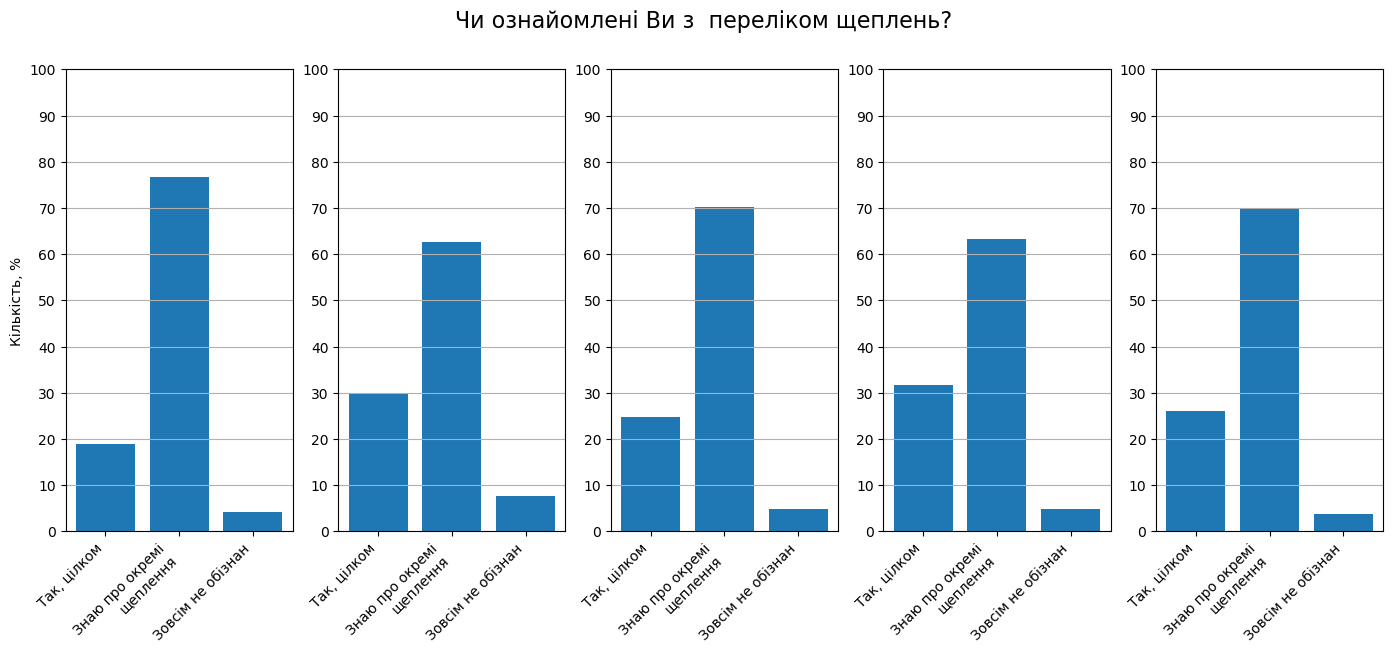

In [79]:
plot_cat(b3_df, b3_cl, b3_dict, 'Чи ознайомлені Ви з  переліком щеплень?')

##### 2) поле B4:

In [80]:
b4_df = task3_df[task3_df['B4'] != ' ']

In [81]:
b4_cl = cluster_cat('B4', b4_df)

Порядок записи: [2 1 3]


In [61]:
b4_dict = {2: 'Так, цілком', 
           1: 'Знаю про окремі\nщеплення', 
           3: 'Зовсім не обізнан'}

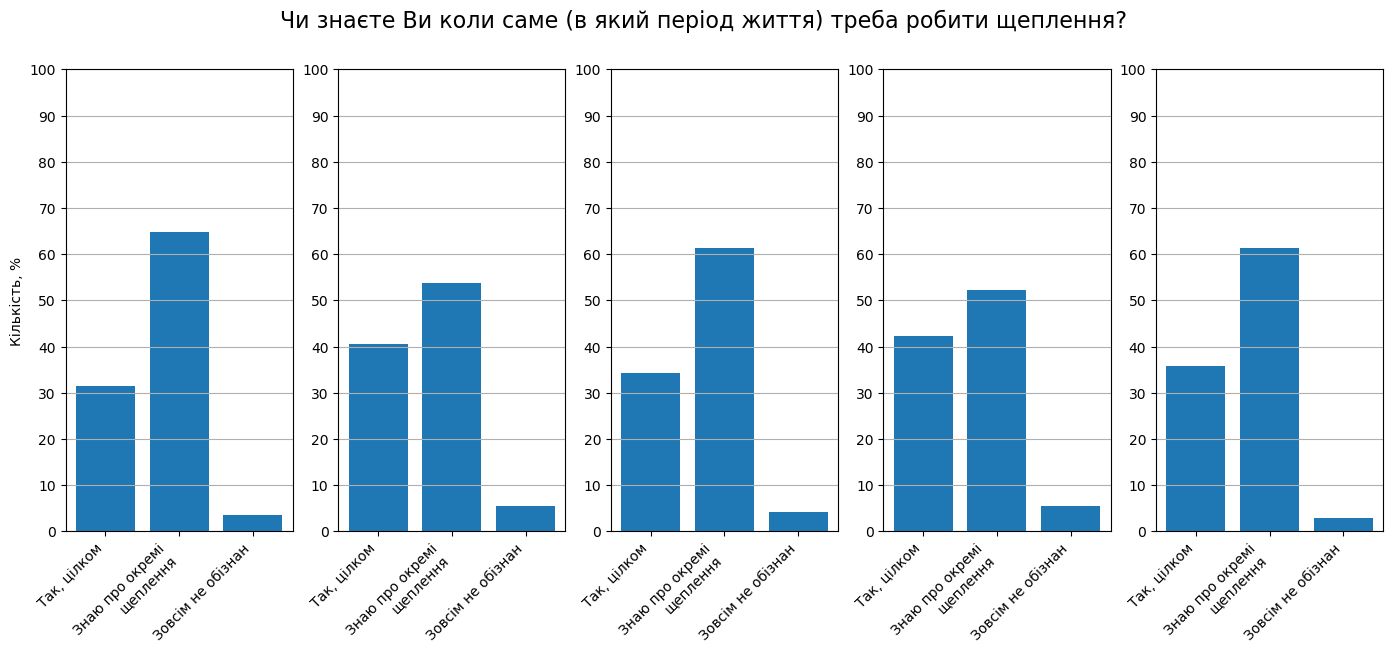

In [62]:
plot_cat(b4_df, b4_cl, b4_dict, 'Чи знаєте Ви коли саме (в який період життя) треба робити щеплення?')

##### 3) поле B6:

In [63]:
b6_df = task3_df[task3_df['B6'] != ' ']

In [64]:
b6_cl = cluster_cat('B6', b6_df)

Порядок записи: [1 2 3]


In [65]:
b6_dict = {1: 'Так', 
           2: 'Hi', 
           3: 'Важко сказати'}

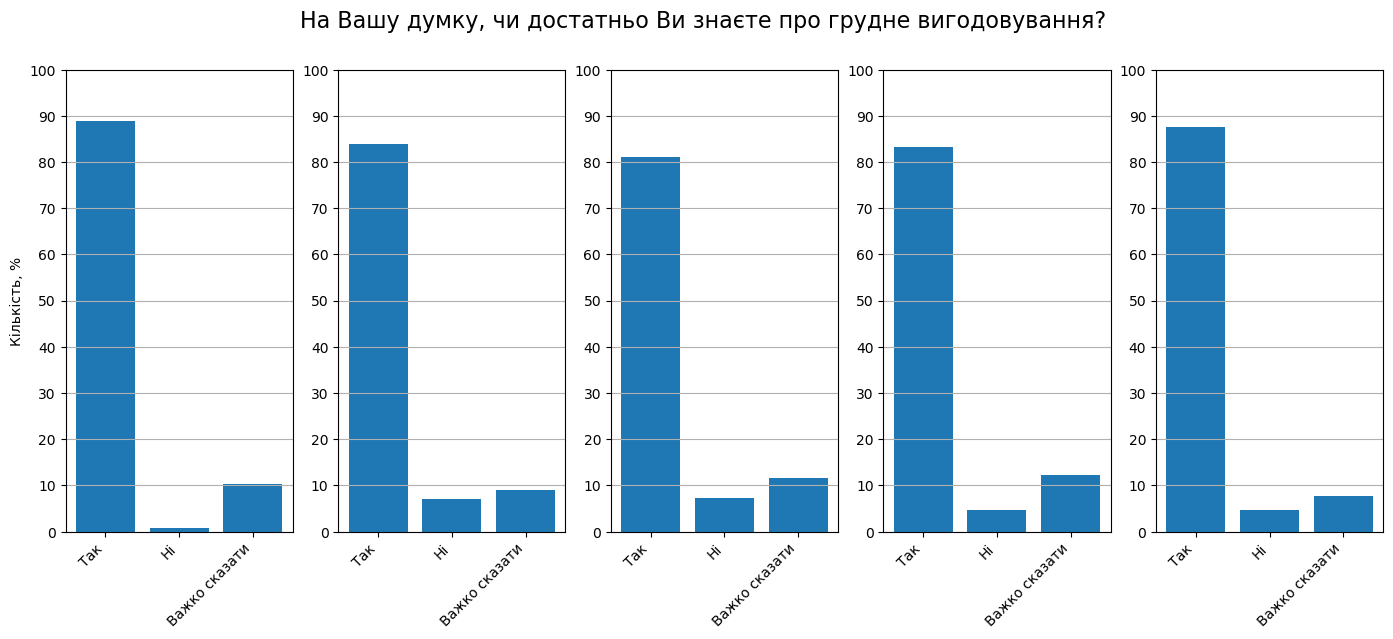

In [66]:
plot_cat(b6_df, b6_cl, b6_dict, 'На Вашу думку, чи достатньо Ви знаєте про грудне вигодовування?')

##### 4) поле G2:

In [82]:
g2_df = task3_df[task3_df['G2'] != ' ']

In [83]:
g2_cl = cluster_cat('G2', g2_df)

Порядок записи: [2 1 4 3]


In [84]:
g2_dict = {2: 'Майже всi \nплановi', 
           1: 'Щоразу, за \nплановим оглядом', 
           4: 'Жодного разу',
           3: 'Бiльшiсть \nпропущено'}

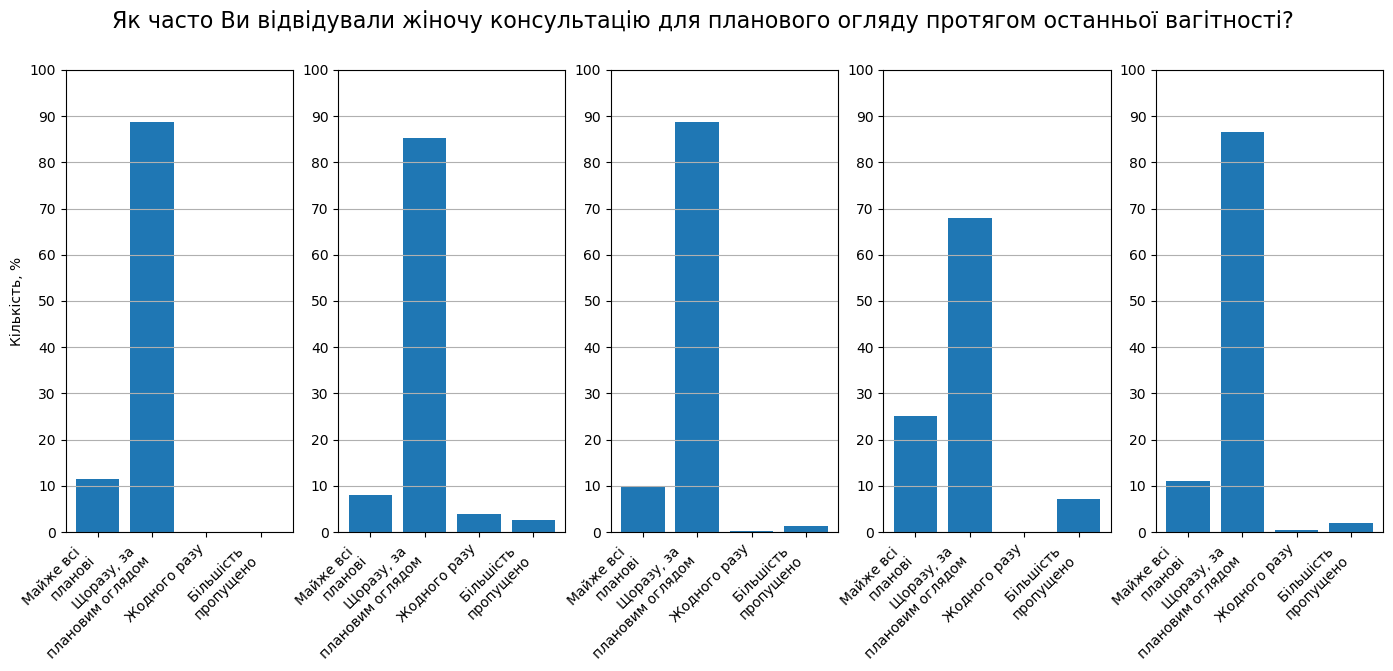

In [70]:
plot_cat(g2_df, g2_cl, g2_dict, 'Як часто Ви відвідували жіночу консультацію для планового огляду протягом останньої вагітності?')

##### 5) поле B1:

In [89]:
b1_df = task3_df[task3_df['B1_1'] != ' ']

In [90]:
b1_cl = cluster_cat('B1_1', b1_df)

Порядок записи: [1 2]


In [91]:
b1_dict = {1: 'Так', 
           2: 'Ні'}

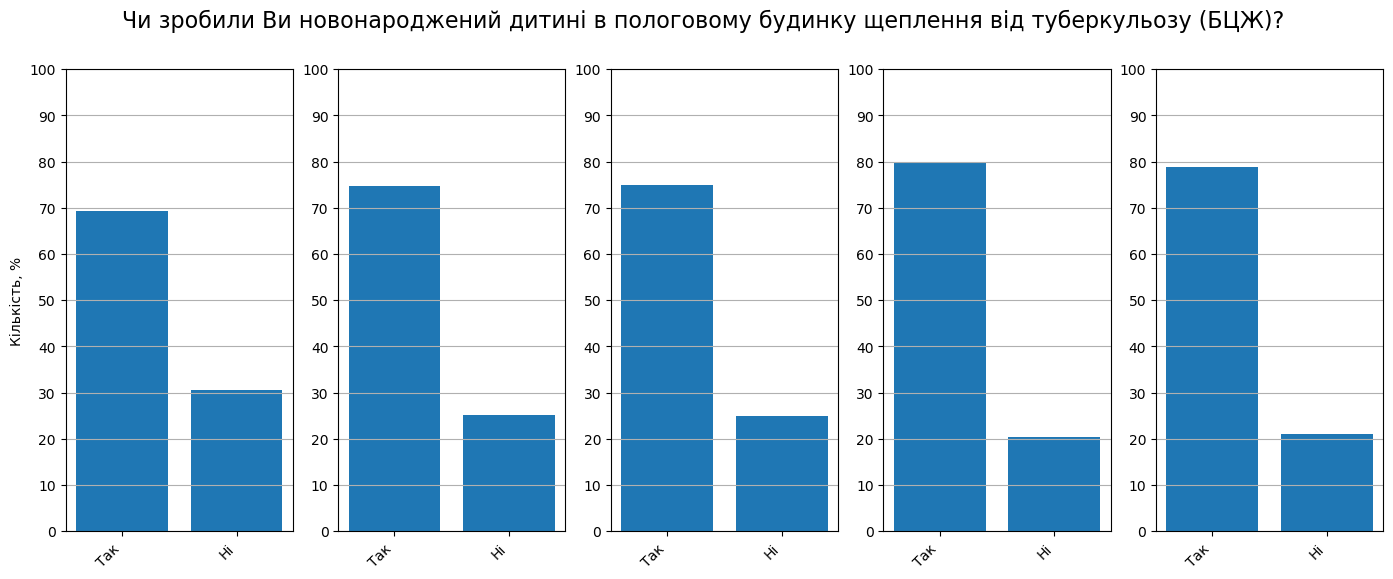

In [95]:
plot_cat(b1_df, b1_cl, b1_dict, 'Чи зробили Ви новонароджений дитині в пологовому будинку щеплення від туберкульозу (БЦЖ)?')

###### 6) поле В1_2:

In [102]:
b1_2_df = task3_df[task3_df['B1_2'] != ' ']

C:\Users\Nastya\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [104]:
b1_2_cl = cluster_cat('B1_2', b1_2_df)

Порядок записи: [1 2]


In [105]:
b1_2_dict = {1: 'Так', 
           2: 'Ні'}

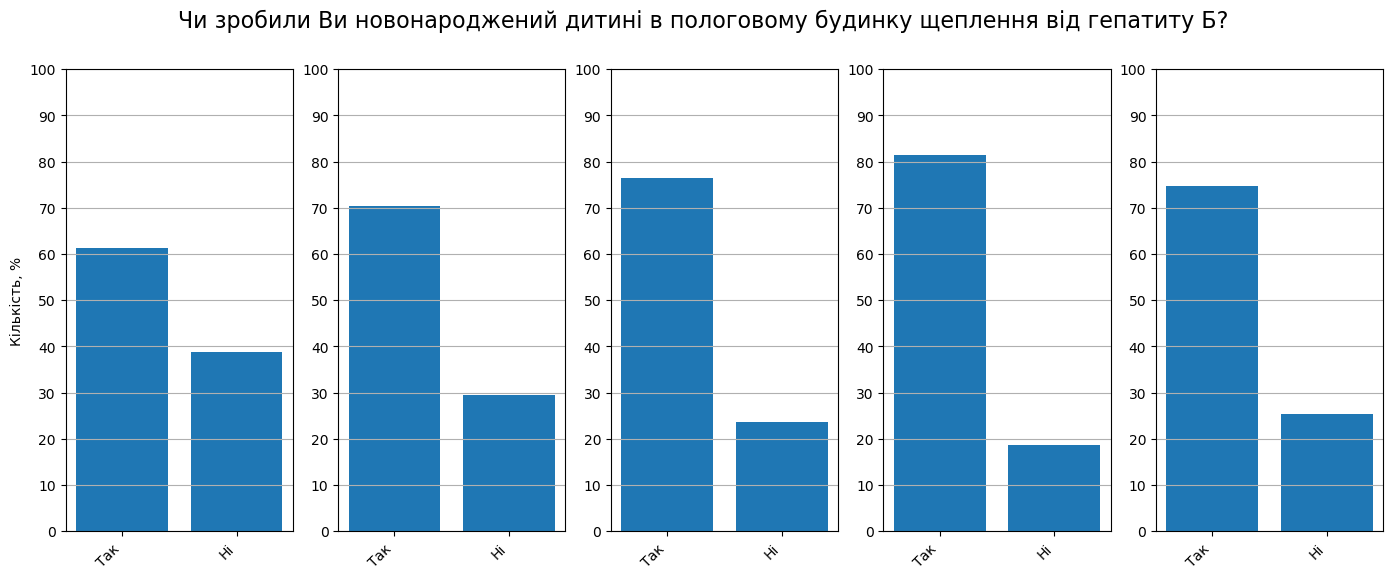

In [108]:
plot_cat(b1_2_df, b1_2_cl, b1_2_dict, 'Чи зробили Ви новонароджений дитині в пологовому будинку щеплення від гепатиту Б?')

Визначення способу інформування:

In [111]:
a2_df = task3_df[task3_df['A2'] != ' ']
a2_cl = cluster_cat('A2', a2_df)

Порядок записи: [7 6 1 5 2 4 3 8]


In [112]:
a2_dict = {7: 'Зі ЗМІ/телебачення', 
           6: 'З новин в Інтернеті/соціальних мережах',
           1: 'В жіночій консультації',
           5: 'З офіційного веб-сайту цієї ініціативи',
           2: 'У пологовому будинку',
           4: 'Від друзів, знайомих',
           3: 'В управлінні соціального захисту',
           8: 'Інше'}

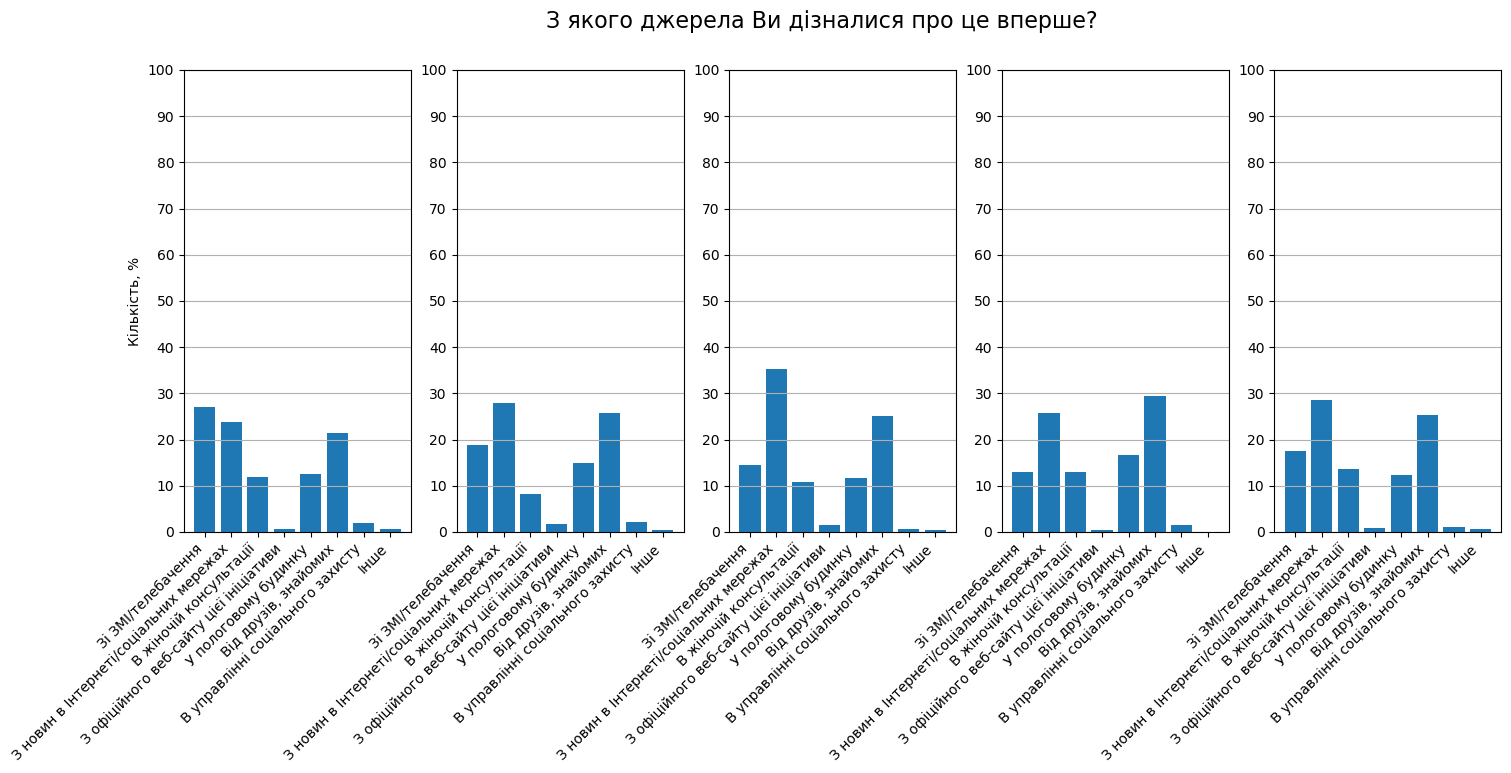

In [113]:
plot_cat(a2_df, a2_cl, a2_dict, 'З якого джерела Ви дізналися про це вперше?')

In [114]:
a3_df = task3_df[task3_df['A3'] != ' ']
a3_cl = cluster_cat('A3', a3_df)

Порядок записи: [2 1 4 3 5 8 6 7]


In [116]:
a3_dict = {2: 'В жіночій консультації', 
           1: 'Через офіційний веб-сайт цієї ініціативи',
           4: 'В управлінні соціального захисту',
           3: 'У пологовому будинку',
           5: 'Інтернет/ соціальні мережі',
           8: 'Друзі',
           6: 'ЗМІ',
           7: 'Інше'}

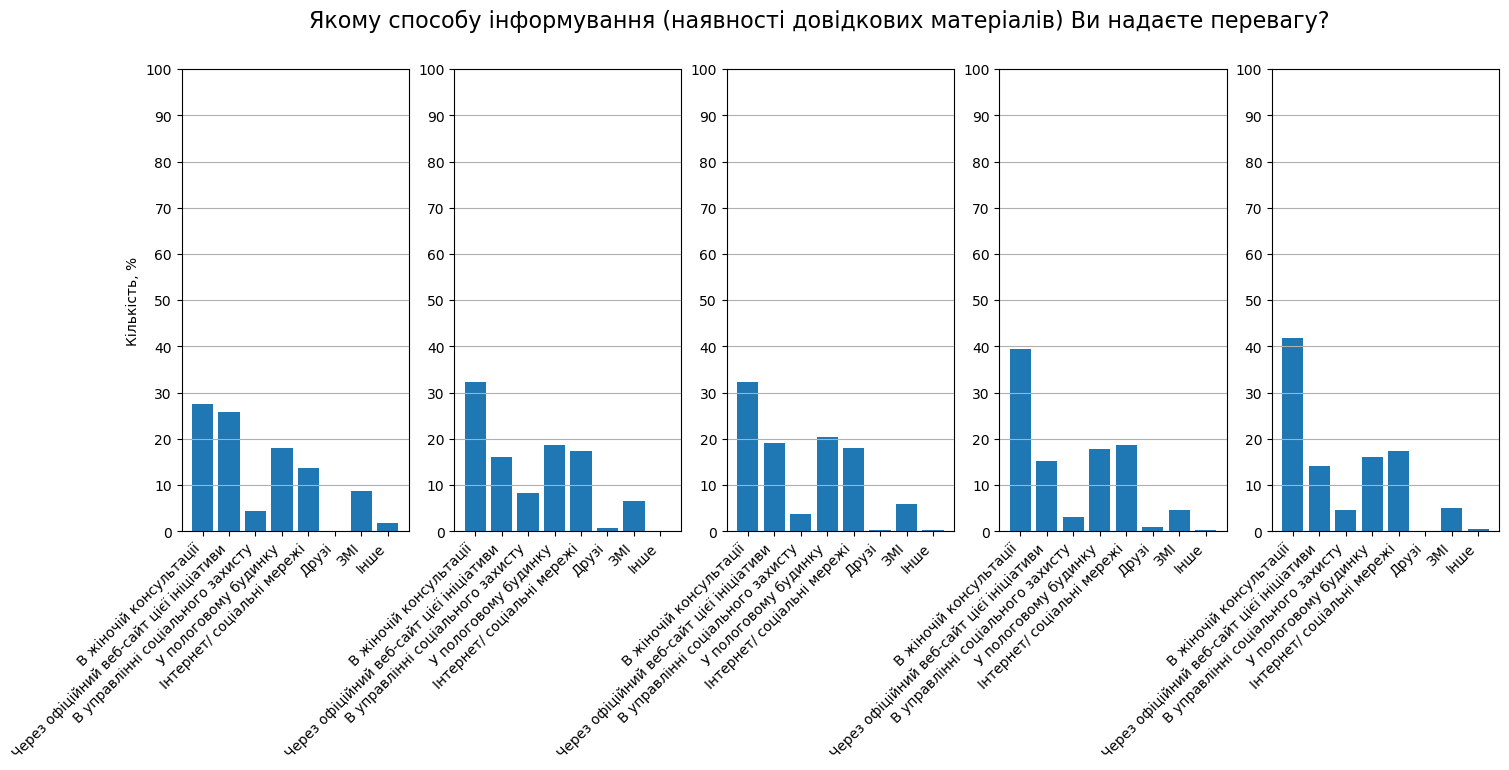

In [117]:
plot_cat(a3_df, a3_cl, a3_dict, 'Якому способу інформування (наявності довідкових матеріалів) Ви надаєте перевагу?')